In [ ]:
import pandas as pd
import numpy as np
import glob
import os

# Time encoding function
def encode_time(value, max_value):
    value_sin = np.sin(2 * np.pi * value / max_value)
    value_cos = np.cos(2 * np.pi * value / max_value)
    return value_sin, value_cos

# Function to process marginal data
def process_marginal(file_path):
    print(f"Processing marginal file: {file_path}")
    try:
        data = pd.read_csv(file_path)
        data = data.rename(columns={'DA ES': 'DA'})
        data = data[['Year', 'Month', 'Day', 'Hour', 'DA']].dropna()
        return data
    except Exception as e:
        print(f"Error processing marginal file {file_path}: {e}")
        return None

# Function to process intra-day data
def process_intra_day(file_path):
    print(f"Processing intra-day file: {file_path}")
    try:
        data = pd.read_csv(file_path)
        data = data.rename(columns={'AvgES': 'ID'})
        data = data[['Year', 'Month', 'Day', 'Hour', 'ID']].dropna()
        return data
    except Exception as e:
        print(f"Error processing intra-day file {file_path}: {e}")
        return None


# Function to process gas price data
def process_gas(file_paths):
    print("Processing gas price files...")
    all_gas_data = []
    for file_path in file_paths:
        try:
            # Load the Excel file
            gas_data = pd.read_excel(file_path, sheet_name="Regulated gas")
            
            # Use column positions to rename, assuming consistent format
            gas_data = gas_data.rename(columns={
                gas_data.columns[0]: 'Trading_Day',
                gas_data.columns[4]: 'Price_EUR_MWh',
                gas_data.columns[5]: 'Volume_MWh'
            })
            
            # Convert 'Trading_Day' to datetime
            gas_data['Trading_Day'] = pd.to_datetime(gas_data['Trading_Day'], errors='coerce')
            
            # Drop rows with invalid dates
            gas_data = gas_data.dropna(subset=['Trading_Day'])
            
            # Extract Year, Month, and Day for merging
            gas_data['Year'] = gas_data['Trading_Day'].dt.year
            gas_data['Month'] = gas_data['Trading_Day'].dt.month
            gas_data['Day'] = gas_data['Trading_Day'].dt.day
            
            # Sort the data to ensure proper forward-fill order
            gas_data = gas_data.sort_values(by=['Year', 'Month', 'Day'])
            
            # Fill missing prices and volumes using forward-fill
            gas_data['Price_EUR_MWh'] = gas_data['Price_EUR_MWh'].fillna(method='ffill')
            gas_data['Volume_MWh'] = gas_data['Volume_MWh'].fillna(method='ffill')
            
            # Keep only relevant columns
            gas_data = gas_data[['Year', 'Month', 'Day', 'Price_EUR_MWh', 'Volume_MWh']]
            
            # Append to the list
            all_gas_data.append(gas_data)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    
    # Combine all gas data
    combined_gas_data = pd.concat(all_gas_data, ignore_index=True)
    
    # Remove duplicates
    combined_gas_data = combined_gas_data.drop_duplicates(subset=['Year', 'Month', 'Day'])
    
    print("Gas data processed successfully.")
    return combined_gas_data

In [33]:
import pandas as pd
import numpy as np
import glob
import os

# Define directories
data_dir = '../raw_data/'
output_dir = '../formatted_data/'

# Discover files
marginal_files = glob.glob(os.path.join(data_dir, 'data_electric/data_da*.csv'))
intra_day_files = glob.glob(os.path.join(data_dir, 'data_electric/data_id*.csv'))
gas_files = glob.glob(os.path.join(data_dir, 'data_gas/original_gas/*.xlsx'))

print(f"Found {len(marginal_files)} marginal files")
print(f"Found {len(intra_day_files)} intra-day files")
print(f"Found {len(gas_files)} gas price files")

# Time encoding function
def encode_time(value, max_value):
    value_sin = np.sin(2 * np.pi * value / max_value)
    value_cos = np.cos(2 * np.pi * value / max_value)
    return value_sin, value_cos

# Process marginal and intra-day data
marginal_data = pd.concat(
    [df for file in marginal_files if (df := process_marginal(file)) is not None and not df.empty],
    ignore_index=True
)
intra_day_data = pd.concat(
    [df for file in intra_day_files if (df := process_intra_day(file)) is not None and not df.empty],
    ignore_index=True
)

# Process gas data from XLSX files
gas_data = process_gas(gas_files)

# Merge marginal and intra-day data
final_data = pd.merge(marginal_data, intra_day_data, on=['Year', 'Month', 'Day', 'Hour'], how='inner')

# Optionally merge gas price data
final_data = pd.merge(final_data, gas_data, on=['Year', 'Month', 'Day'], how='left')

# Add encoded time columns
final_data['Hour_Sin'], final_data['Hour_Cos'] = zip(*final_data['Hour'].apply(lambda x: encode_time(x, 24)))
final_data['Day_Sin'], final_data['Day_Cos'] = zip(*final_data['Day'].apply(lambda x: encode_time(x, 31)))
final_data['Month_Sin'], final_data['Month_Cos'] = zip(*final_data['Month'].apply(lambda x: encode_time(x, 12)))

# Add scaled Year and price difference
final_data['Year_Scaled'] = (final_data['Year'] - 2018) * 0.1 + 0.1
final_data['Diff'] = final_data['DA'] - final_data['ID']

# Save the processed data
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'formatted_data.csv')
final_data.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

# Validation
missing_values = final_data.isnull().sum()
print("Missing values:")
print(missing_values)

duplicate_dates = final_data.duplicated(subset=['Year', 'Month', 'Day', 'Hour'])
print("Number of duplicate dates:", duplicate_dates.sum())


Found 2 marginal files
Found 2 intra-day files
Found 7 gas price files
Processing marginal file: ../raw_data/data_electric/data_da_23.csv
Processing marginal file: ../raw_data/data_electric/data_da_24.csv
Processing intra-day file: ../raw_data/data_electric/data_id_24.csv
Processing intra-day file: ../raw_data/data_electric/data_id_23.csv
Processing gas price files...


/tmp/ipykernel_779085/840273746.py:71: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gas_data['Price_EUR_MWh'] = gas_data['Price_EUR_MWh'].fillna(method='ffill')
/tmp/ipykernel_779085/840273746.py:72: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gas_data['Volume_MWh'] = gas_data['Volume_MWh'].fillna(method='ffill')
/tmp/ipykernel_779085/840273746.py:71: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gas_data['Price_EUR_MWh'] = gas_data['Price_EUR_MWh'].fillna(method='ffill')
/tmp/ipykernel_779085/840273746.py:72: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gas_data['Volume_MWh'] = gas_data['Volume_MWh'].fillna(method='ffill')
/tmp/ipy

Gas data processed successfully.
Processed data saved to ../formatted_data/formatted_data.csv
Missing values:
Year                0
Month               0
Day                 0
Hour                0
DA                  0
ID                  0
Price_EUR_MWh    6527
Volume_MWh       6527
Hour_Sin            0
Hour_Cos            0
Day_Sin             0
Day_Cos             0
Month_Sin           0
Month_Cos           0
Year_Scaled         0
Diff                0
dtype: int64
Number of duplicate dates: 0


In [34]:
import pandas as pd

# Load the final file
final_data = pd.read_csv('../formatted_data/formatted_data.csv')

# Check for missing values in `Price_EUR_MWh` and `Volume_MWh`
missing_price = final_data[final_data['Price_EUR_MWh'].isnull()]
missing_volume = final_data[final_data['Volume_MWh'].isnull()]

# Split missing data by year and month
missing_price_by_year_month = missing_price.groupby(['Year', 'Month']).size().reset_index(name='Missing_Price_Count')
missing_volume_by_year_month = missing_volume.groupby(['Year', 'Month']).size().reset_index(name='Missing_Volume_Count')

# Merge the results for comparison
missing_summary = pd.merge(
    missing_price_by_year_month,
    missing_volume_by_year_month,
    on=['Year', 'Month'],
    how='outer'
).fillna(0)  # Fill NaN with 0 for missing counts

# Save results to CSV for reference
missing_summary.to_csv('../formatted_data/missing_summary.csv', index=False)

# Print results
print("Summary of missing values by Year and Month:")
print(missing_summary)


Summary of missing values by Year and Month:
      Year  Month  Missing_Price_Count  Missing_Volume_Count
0   2023.0    1.0                  168                   168
1   2023.0    2.0                   24                    24
2   2023.0    3.0                   96                    96
3   2023.0    4.0                   24                    24
4   2023.0    5.0                   48                    48
5   2023.0    6.0                  120                   120
6   2023.0    7.0                  720                   720
7   2023.0    8.0                  168                   168
8   2023.0    9.0                  144                   144
9   2023.0   10.0                  240                   240
10  2023.0   11.0                  288                   288
11  2023.0   12.0                  336                   336
12  2024.0    1.0                  264                   264
13  2024.0    2.0                  216                   216
14  2024.0    3.0                  383  

In [5]:
# Function to process weather data with forward-fill (excluding latitude and longitude)
def process_weather(file_paths):
    print("Processing weather data files...")
    all_weather_data = []
    for file_path in file_paths:
        try:
            # Read the weather data
            weather_data = pd.read_csv(file_path)
            weather_data['valid_time'] = pd.to_datetime(weather_data['valid_time'])
            weather_data['Year'] = weather_data['valid_time'].dt.year
            weather_data['Month'] = weather_data['valid_time'].dt.month
            weather_data['Day'] = weather_data['valid_time'].dt.day
            weather_data['Hour'] = weather_data['valid_time'].dt.hour
            
            # Drop latitude and longitude columns
            columns_to_drop = [col for col in weather_data.columns if '_latitude' in col or '_longitude' in col]
            weather_data = weather_data.drop(columns=columns_to_drop)

            # Create a complete time index
            min_date = weather_data['valid_time'].min()
            max_date = weather_data['valid_time'].max()
            complete_time_index = pd.date_range(min_date, max_date, freq='H')

            # Create a DataFrame with the complete index
            complete_time_df = pd.DataFrame({'valid_time': complete_time_index})
            complete_time_df['Year'] = complete_time_df['valid_time'].dt.year
            complete_time_df['Month'] = complete_time_df['valid_time'].dt.month
            complete_time_df['Day'] = complete_time_df['valid_time'].dt.day
            complete_time_df['Hour'] = complete_time_df['valid_time'].dt.hour

            # Merge weather data with the complete time index
            weather_data = pd.merge(complete_time_df, weather_data, on=['valid_time', 'Year', 'Month', 'Day', 'Hour'], how='left')

            # Forward-fill missing values
            weather_data = weather_data.sort_values(by=['valid_time'])
            weather_data = weather_data.fillna(method='ffill')

            # Drop the valid_time column for consistency
            weather_data = weather_data.drop(columns=['valid_time'])

            all_weather_data.append(weather_data)
        except Exception as e:
            print(f"Error processing weather file {file_path}: {e}")

    # Combine all weather data
    combined_weather_data = pd.concat(all_weather_data, ignore_index=True)
    print("Weather data processed successfully with forward-fill (latitude and longitude removed).")
    return combined_weather_data

# Rest of the script remains unchanged
# Process datasets
marginal_data = pd.concat(
    [df for file in marginal_files if (df := process_marginal(file)) is not None and not df.empty],
    ignore_index=True
)
intra_day_data = pd.concat(
    [df for file in intra_day_files if (df := process_intra_day(file)) is not None and not df.empty],
    ignore_index=True
)
gas_data = process_gas(gas_files)
weather_data = process_weather(weather_files)

# Merge datasets
final_data = pd.merge(marginal_data, intra_day_data, on=['Year', 'Month', 'Day', 'Hour'], how='inner')
final_data = pd.merge(final_data, gas_data, on=['Year', 'Month', 'Day'], how='left')
final_data = pd.merge(final_data, weather_data, on=['Year', 'Month', 'Day', 'Hour'], how='left')

# Add encoded time columns
final_data['Hour_Sin'], final_data['Hour_Cos'] = zip(*final_data['Hour'].apply(lambda x: encode_time(x, 24)))
final_data['Day_Sin'], final_data['Day_Cos'] = zip(*final_data['Day'].apply(lambda x: encode_time(x, 31)))
final_data['Month_Sin'], final_data['Month_Cos'] = zip(*final_data['Month'].apply(lambda x: encode_time(x, 12)))

# Add scaled Year and price difference
final_data['Year_Scaled'] = (final_data['Year'] - 2018) * 0.1 + 0.1
final_data['Diff'] = final_data['DA'] - final_data['ID']

# Save the processed data
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'formatted_data.csv')
final_data.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

# Validation
missing_values = final_data.isnull().sum()
print("Missing values:")
print(missing_values)

duplicate_dates = final_data.duplicated(subset=['Year', 'Month', 'Day', 'Hour'])
print("Number of duplicate dates:", duplicate_dates.sum())


Processing marginal file: ../raw_data/data_electric/data_da_23.csv
Processing marginal file: ../raw_data/data_electric/data_da_24.csv
Processing intra-day file: ../raw_data/data_electric/data_id_24.csv
Processing intra-day file: ../raw_data/data_electric/data_id_23.csv
Processing gas price files...


/tmp/ipykernel_121852/3508820259.py:69: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gas_data['Price_EUR_MWh'] = gas_data['Price_EUR_MWh'].fillna(method='ffill')
/tmp/ipykernel_121852/3508820259.py:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gas_data['Volume_MWh'] = gas_data['Volume_MWh'].fillna(method='ffill')
/tmp/ipykernel_121852/3508820259.py:69: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gas_data['Price_EUR_MWh'] = gas_data['Price_EUR_MWh'].fillna(method='ffill')
/tmp/ipykernel_121852/3508820259.py:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gas_data['Volume_MWh'] = gas_data['Volume_MWh'].fillna(method='ffill')
/tmp

Gas data processed successfully.
Processing weather data files...
Weather data processed successfully with forward-fill (latitude and longitude removed).
Processed data saved to ../formatted_data/formatted_data.csv
Missing values:
Year           0
Month          0
Day            0
Hour           0
DA             0
              ..
Day_Cos        0
Month_Sin      0
Month_Cos      0
Year_Scaled    0
Diff           0
Length: 82, dtype: int64
Number of duplicate dates: 21


In [6]:
import pandas as pd
import os

# Define the formatted data file path
formatted_file_path = '../formatted_data/formatted_data.csv'

# Check if the file exists
if not os.path.exists(formatted_file_path):
    print(f"Error: File '{formatted_file_path}' not found.")
else:
    # Load the formatted data
    try:
        data = pd.read_csv(formatted_file_path)
        
        # Print the length of the file (number of rows)
        print(f"Number of rows in the file: {len(data)}")
        
        # Print all columns in the file
        columns = data.columns.tolist()
        print("\nColumns in the file:")
        for col in columns:
            print(f" - {col}")
        
        # Identify missing columns (columns with missing values)
        missing_values = data.isnull().sum()
        missing_columns = missing_values[missing_values > 0]
        print("\nColumns with missing values:")
        if not missing_columns.empty:
            for col, count in missing_columns.items():
                print(f" - {col}: {count} missing values")
        else:
            print(" - No missing values found.")
    except Exception as e:
        print(f"Error reading the file: {e}")


Number of rows in the file: 16819

Columns in the file:
 - Year
 - Month
 - Day
 - Hour
 - DA
 - ID
 - Price_EUR_MWh
 - Volume_MWh
 - Andalusia (Wind)_temperature
 - Andalusia (Wind)_solar_radiation
 - Andalusia (Wind)_wind_u_component
 - Andalusia (Wind)_wind_v_component
 - Andalusia (Wind)_surface_pressure
 - Andalusia (Wind)_total_precipitation
 - Aragon (Wind)_temperature
 - Aragon (Wind)_solar_radiation
 - Aragon (Wind)_wind_u_component
 - Aragon (Wind)_wind_v_component
 - Aragon (Wind)_surface_pressure
 - Aragon (Wind)_total_precipitation
 - Barcelona_temperature
 - Barcelona_solar_radiation
 - Barcelona_wind_u_component
 - Barcelona_wind_v_component
 - Barcelona_surface_pressure
 - Barcelona_total_precipitation
 - Bilbao_temperature
 - Bilbao_solar_radiation
 - Bilbao_wind_u_component
 - Bilbao_wind_v_component
 - Bilbao_surface_pressure
 - Bilbao_total_precipitation
 - Castile-La Mancha (Wind)_temperature
 - Castile-La Mancha (Wind)_solar_radiation
 - Castile-La Mancha (Wind)_w

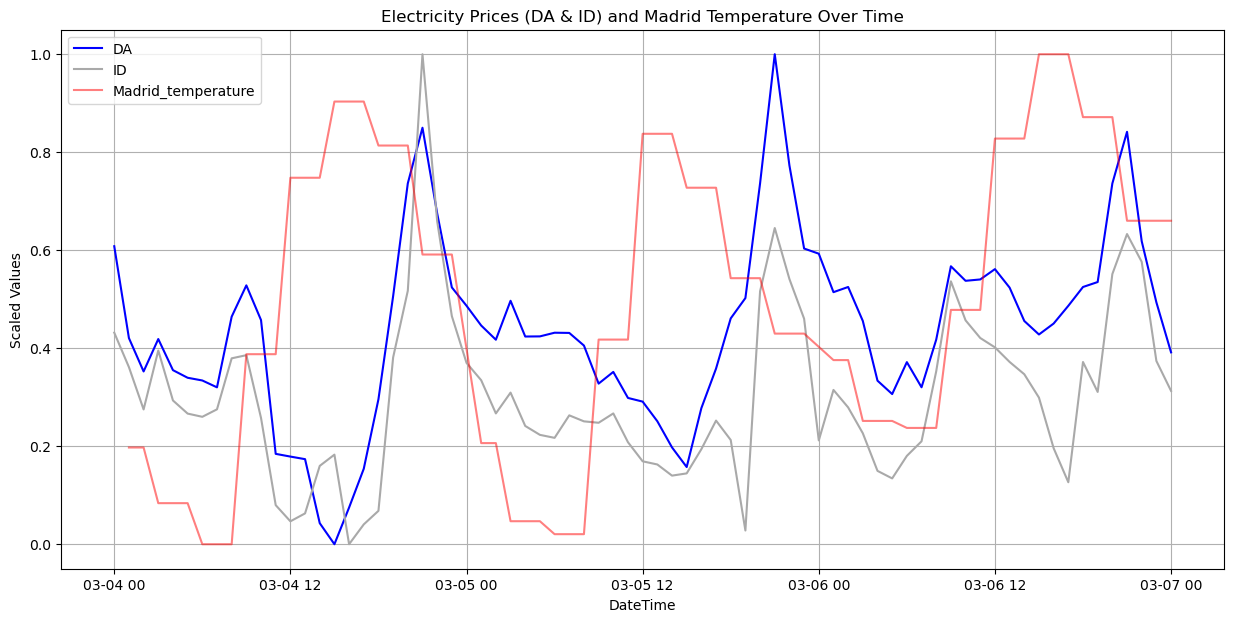

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the data
file_path = '../formatted_data/formatted_data.csv'
data = pd.read_csv(file_path)

# Convert Year, Month, Day, Hour to datetime
data['DateTime'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour']])

# User selects start and end date
start_date = '2023-03-04'
end_date = '2023-03-07'

# Filter data within the date range
mask = (data['DateTime'] >= start_date) & (data['DateTime'] <= end_date)
selected_data = data.loc[mask].reset_index(drop=True)

# Fill missing values with interpolation
selected_data['Madrid_temperature'] = selected_data['Madrid_temperature'].interpolate(method='linear')

# Choose specific variables to plot
variables_to_plot = ['DA', 'ID', 'Madrid_temperature']

# Normalize the data to bring all variables to the same scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(selected_data[variables_to_plot])

# Create a DataFrame for the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=variables_to_plot)
scaled_df['DateTime'] = selected_data['DateTime']

# Define colors for the variables
colors = {'DA': 'blue', 'ID': 'darkgrey', 'Madrid_temperature': 'red'}

# Plot all variables on the same plot
plt.figure(figsize=(15, 7))
for var in variables_to_plot:
    if var == 'Madrid_temperature':
        # Add transparency for temperature data
        plt.plot(scaled_df['DateTime'], scaled_df[var], label=var, color=colors[var], alpha=0.5)
    else:
        plt.plot(scaled_df['DateTime'], scaled_df[var], label=var, color=colors[var])

# Add labels, title, legend, and grid
plt.title('Electricity Prices (DA & ID) and Madrid Temperature Over Time')
plt.xlabel('DateTime')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


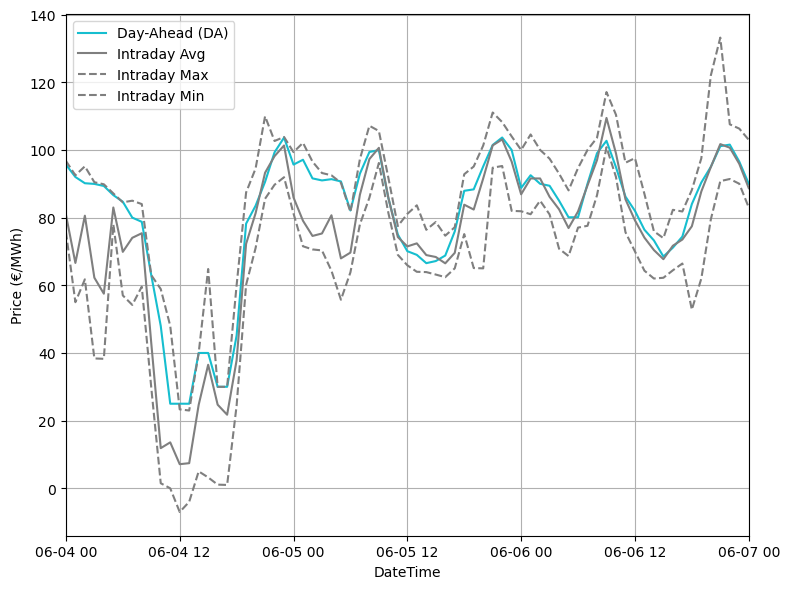

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
da_file = '/home/teitur/DTU/electricproject/deeplearning/raw_data/data_electric/data_da_23.csv'
id_file = '/home/teitur/DTU/electricproject/deeplearning/raw_data/data_electric/data_id_23.csv'

# Load Day-Ahead (DA) data
da_data = pd.read_csv(da_file)
da_data['DateTime'] = pd.to_datetime(da_data[['Year', 'Month', 'Day', 'Hour']])
da_data = da_data[['DateTime', 'DA ES']].rename(columns={'DA ES': 'DA'})

# Load Intraday (ID) data
id_data = pd.read_csv(id_file)
id_data['DateTime'] = pd.to_datetime(id_data[['Year', 'Month', 'Day', 'Hour']])
id_data = id_data[['DateTime', 'MaxES', 'MinES', 'AvgES']]

# Merge the data on DateTime
merged_data = pd.merge(da_data, id_data, on='DateTime')

# User-selected date range
start_date = '2023-06-04'
end_date = '2023-06-07'
mask = (merged_data['DateTime'] >= start_date) & (merged_data['DateTime'] <= end_date)
selected_data = merged_data.loc[mask].reset_index(drop=True)

# Plotting
plt.figure(figsize=(8, 6))

# Plot DA prices
plt.plot(
    selected_data['DateTime'], selected_data['DA'],
    label='Day-Ahead (DA)', color='#16BECF', linewidth=1.5
)

# Plot Intraday prices
plt.plot(
    selected_data['DateTime'], selected_data['AvgES'],
    label='Intraday Avg', color='#7F7F7F', linewidth=1.5
)
plt.plot(
    selected_data['DateTime'], selected_data['MaxES'],
    label='Intraday Max', color='#7F7F7F', linestyle='dashed', linewidth=1.5
)
plt.plot(
    selected_data['DateTime'], selected_data['MinES'],
    label='Intraday Min', color='#7F7F7F', linestyle='dashed', linewidth=1.5
)

# Add labels, title, and legend
plt.xlabel("DateTime")
plt.ylabel("Price (€/MWh)")
plt.legend()

# Set x-axis limits to match data range
plt.xlim(selected_data['DateTime'].iloc[0], selected_data['DateTime'].iloc[-1])

# Add grid for readability
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


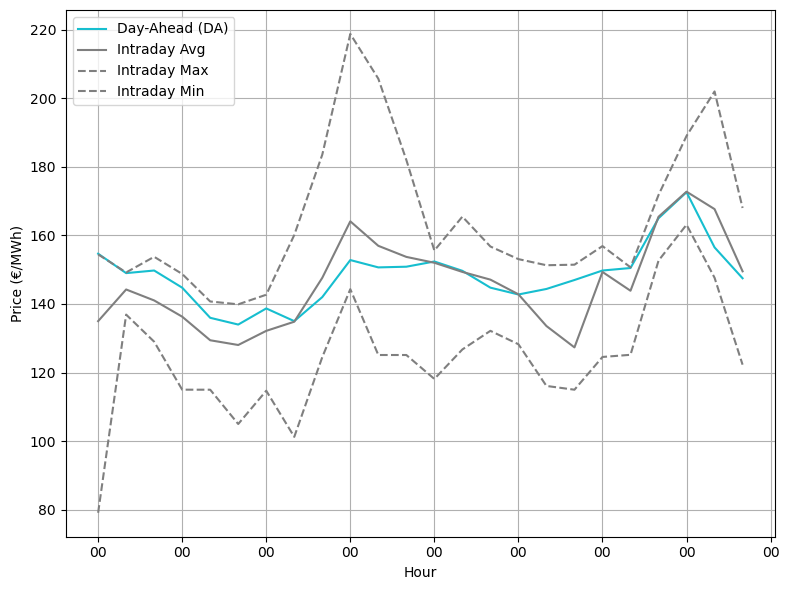

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
da_file = '/home/teitur/DTU/electricproject/deeplearning/raw_data/data_electric/data_da_23.csv'
id_file = '/home/teitur/DTU/electricproject/deeplearning/raw_data/data_electric/data_id_23.csv'

# Load Day-Ahead (DA) data
da_data = pd.read_csv(da_file)
da_data['DateTime'] = pd.to_datetime(da_data[['Year', 'Month', 'Day', 'Hour']])
da_data = da_data[['DateTime', 'DA ES']].rename(columns={'DA ES': 'DA'})

# Load Intraday (ID) data
id_data = pd.read_csv(id_file)
id_data['DateTime'] = pd.to_datetime(id_data[['Year', 'Month', 'Day', 'Hour']])
id_data = id_data[['DateTime', 'MaxES', 'MinES', 'AvgES']]

# Merge the data on DateTime
merged_data = pd.merge(da_data, id_data, on='DateTime')

# User-selected date (24-hour slot)
selected_date = '2023-03-06'
mask = (merged_data['DateTime'].dt.date == pd.to_datetime(selected_date).date())
selected_data = merged_data.loc[mask].reset_index(drop=True)

# Plotting
plt.figure(figsize=(8, 6))  # Adjust figsize for clarity

# Plot DA prices
plt.plot(
    selected_data['DateTime'], selected_data['DA'],
    label='Day-Ahead (DA)', color='#16BECF', linewidth=1.5
)

# Plot Intraday prices
plt.plot(
    selected_data['DateTime'], selected_data['AvgES'],
    label='Intraday Avg', color='#7F7F7F', linewidth=1.5
)
plt.plot(
    selected_data['DateTime'], selected_data['MaxES'],
    label='Intraday Max', color='#7F7F7F', linestyle='dashed', linewidth=1.5
)
plt.plot(
    selected_data['DateTime'], selected_data['MinES'],
    label='Intraday Min', color='#7F7F7F', linestyle='dashed', linewidth=1.5
)

# Add labels, title, and legend
plt.xlabel("Hour")
plt.ylabel("Price (€/MWh)")
plt.legend()

# Format x-axis to show only the hour
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime('%H')))

# Add grid for readability
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


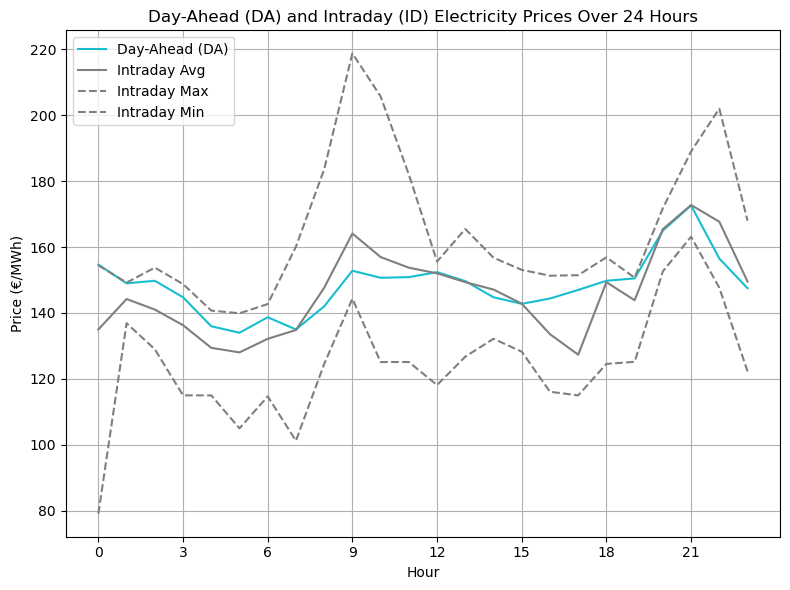

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
da_file = '/home/teitur/DTU/electricproject/deeplearning/raw_data/data_electric/data_da_23.csv'
id_file = '/home/teitur/DTU/electricproject/deeplearning/raw_data/data_electric/data_id_23.csv'

# Load Day-Ahead (DA) data
da_data = pd.read_csv(da_file)
da_data['DateTime'] = pd.to_datetime(da_data[['Year', 'Month', 'Day', 'Hour']])
da_data = da_data[['DateTime', 'DA ES']].rename(columns={'DA ES': 'DA'})

# Load Intraday (ID) data
id_data = pd.read_csv(id_file)
id_data['DateTime'] = pd.to_datetime(id_data[['Year', 'Month', 'Day', 'Hour']])
id_data = id_data[['DateTime', 'MaxES', 'MinES', 'AvgES']]

# Merge the data on DateTime
merged_data = pd.merge(da_data, id_data, on='DateTime')

# User-selected date (24-hour slot)
selected_date = '2023-03-06'
mask = (merged_data['DateTime'].dt.date == pd.to_datetime(selected_date).date())
selected_data = merged_data.loc[mask].reset_index(drop=True)

# Create a list of hours for the x-axis (0 to 23)
hours = list(range(24))

# Plotting
plt.figure(figsize=(8, 6))  # Adjust figsize for clarity

# Plot DA prices
plt.plot(
    hours, selected_data['DA'],
    label='Day-Ahead (DA)', color='#16BECF', linewidth=1.5
)

# Plot Intraday prices
plt.plot(
    hours, selected_data['AvgES'],
    label='Intraday Avg', color='#7F7F7F', linewidth=1.5
)
plt.plot(
    hours, selected_data['MaxES'],
    label='Intraday Max', color='#7F7F7F', linestyle='dashed', linewidth=1.5
)
plt.plot(
    hours, selected_data['MinES'],
    label='Intraday Min', color='#7F7F7F', linestyle='dashed', linewidth=1.5
)

# Add labels, title, and legend
plt.title("Day-Ahead (DA) and Intraday (ID) Electricity Prices Over 24 Hours")
plt.xlabel("Hour")
plt.ylabel("Price (€/MWh)")
plt.legend()

# Set x-ticks to 3-hour intervals
plt.xticks(range(0, 24, 3))

# Add grid for readability
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


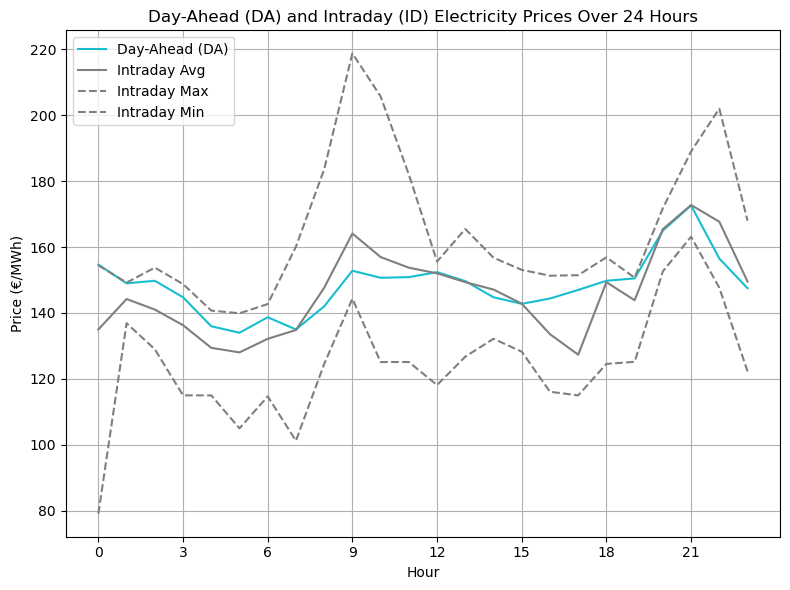

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
da_file = '/home/teitur/DTU/electricproject/deeplearning/raw_data/data_electric/data_da_23.csv'
id_file = '/home/teitur/DTU/electricproject/deeplearning/raw_data/data_electric/data_id_23.csv'

# Load Day-Ahead (DA) data
da_data = pd.read_csv(da_file)
da_data['DateTime'] = pd.to_datetime(da_data[['Year', 'Month', 'Day', 'Hour']])
da_data = da_data[['DateTime', 'DA ES']].rename(columns={'DA ES': 'DA'})

# Load Intraday (ID) data
id_data = pd.read_csv(id_file)
id_data['DateTime'] = pd.to_datetime(id_data[['Year', 'Month', 'Day', 'Hour']])
id_data = id_data[['DateTime', 'MaxES', 'MinES', 'AvgES']]

# Merge the data on DateTime
merged_data = pd.merge(da_data, id_data, on='DateTime')

# User-selected date (24-hour slot)
selected_date = '2023-03-06'
mask = (merged_data['DateTime'].dt.date == pd.to_datetime(selected_date).date())
selected_data = merged_data.loc[mask].reset_index(drop=True)

# Ensure 24 data points
selected_data = selected_data.sort_values(by='DateTime')
selected_data = selected_data.iloc[:24]  # Ensure exactly 24 hours (0 to 23)

# Create a list of hours for the x-axis (0 to 23)
hours = list(range(24))

# Plotting
plt.figure(figsize=(8, 6))  # Adjust figsize for clarity

# Plot DA prices
plt.plot(
    hours, selected_data['DA'],
    label='Day-Ahead (DA)', color='#16BECF', linewidth=1.5
)

# Plot Intraday prices
plt.plot(
    hours, selected_data['AvgES'],
    label='Intraday Avg', color='#7F7F7F', linewidth=1.5
)
plt.plot(
    hours, selected_data['MaxES'],
    label='Intraday Max', color='#7F7F7F', linestyle='dashed', linewidth=1.5
)
plt.plot(
    hours, selected_data['MinES'],
    label='Intraday Min', color='#7F7F7F', linestyle='dashed', linewidth=1.5
)

# Add labels, title, and legend
plt.title("Day-Ahead (DA) and Intraday (ID) Electricity Prices Over 24 Hours")
plt.xlabel("Hour")
plt.ylabel("Price (€/MWh)")
plt.legend()

# Set x-ticks to 3-hour intervals
plt.xticks(range(0, 24, 3))

# Add grid for readability
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()
